In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install statsmodels



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Cell: Imports & settings
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score
)
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [4]:
# Cell: Configure path and sampling
DATA_PATH = r"C:\Users\gokul\Downloads\Fraud.CSV" 
chunk_size = 6362620  
use_sample = True     
sample_frac = 0.1     

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH not found: {DATA_PATH}")
print("DATA_PATH exists:", DATA_PATH)


DATA_PATH exists: C:\Users\gokul\Downloads\Fraud.CSV


In [5]:
# Cell: Load dataset (chunked)
t0 = time()
chunks = []
total = 0
for chunk in pd.read_csv(DATA_PATH, chunksize=chunk_size):
    chunks.append(chunk)
    total += chunk.shape[0]
    print(f"Loaded chunk; cumulative rows read: {total}")
df = pd.concat(chunks, ignore_index=True)
print("Full raw shape:", df.shape)
del chunks
gc.collect()

# Optionally sample
if use_sample and 'isFraud' in df.columns:
    df = df.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    print("Sampled dataset shape:", df.shape)
else:
    print("Using full dataset shape:", df.shape)
print("Loaded in {:.1f}s".format(time()-t0))


Loaded chunk; cumulative rows read: 6362620
Full raw shape: (6362620, 11)
Sampled dataset shape: (636262, 11)
Loaded in 110.9s


In [6]:
# Cell: Inspect columns, dtypes, head
print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
display(df.head())
display(df.describe(include='all').T)


Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

Dtypes:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
1,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
2,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
3,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
4,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,636262.0,NaN,NaN,NaN,243.527333,142.493187,1.0,156.0,239.0,335.0,742.0
type,636262,5,CASH_OUT,223689,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,636262.0,NaN,NaN,NaN,181042.055852,613686.707878,0.0,13362.92,74949.345,209477.175,69337316.27
nameOrig,636262,636172,C2025766746,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,636262.0,NaN,NaN,NaN,828545.160443,2877270.649154,0.0,0.0,14111.815,106956.5,37919816.48
newbalanceOrig,636262.0,NaN,NaN,NaN,849906.518053,2913448.977849,0.0,0.0,0.0,143667.225,37950093.25
nameDest,636262,457351,C1234776885,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,636262.0,NaN,NaN,NaN,1106789.791954,3396119.418539,0.0,0.0,133047.955,950528.955,327998074.22
newbalanceDest,636262.0,NaN,NaN,NaN,1232760.412814,3685490.052177,0.0,0.0,215936.31,1119455.2425,328431698.23
isFraud,636262.0,NaN,NaN,NaN,0.001284,0.035811,0.0,0.0,0.0,0.0,1.0


In [7]:
# Cell: Data cleaning
print("Initial rows:", df.shape[0])

# Drop duplicates
before = df.shape[0]
df.drop_duplicates(inplace=True)
print("Dropped duplicates:", before - df.shape[0])

# Try converting object columns to numeric where possible
for col in df.select_dtypes(include=['object']).columns:
    # skip obvious text columns (names)
    try:
        df[col] = pd.to_numeric(df[col])
        # if successful print minimal info
    except:
        pass

# Drop rows with NA
before = df.shape[0]
df.dropna(inplace=True)
print("Dropped rows with NA:", before - df.shape[0])

# Basic outlier trimming (IQR) on numeric features except target
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'isFraud' in numeric_cols:
    numeric_cols.remove('isFraud')
print("Numeric columns considered for IQR:", numeric_cols)

for col in numeric_cols:
    if df[col].nunique() > 10:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        before = df.shape[0]
        df = df[(df[col] >= lower) & (df[col] <= upper)]
        after = df.shape[0]
        if before != after:
            print(f"Trimmed {col}: removed {before-after} rows")

print("After cleaning rows:", df.shape[0])
gc.collect()


Initial rows: 636262
Dropped duplicates: 0
Dropped rows with NA: 0
Numeric columns considered for IQR: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud']
Trimmed step: removed 10366 rows
Trimmed amount: removed 33353 rows
Trimmed oldbalanceOrg: removed 104438 rows
Trimmed newbalanceOrig: removed 91152 rows
Trimmed oldbalanceDest: removed 52667 rows
Trimmed newbalanceDest: removed 25040 rows
After cleaning rows: 319246


0

isFraud
0    319018
1       228
Name: count, dtype: int64


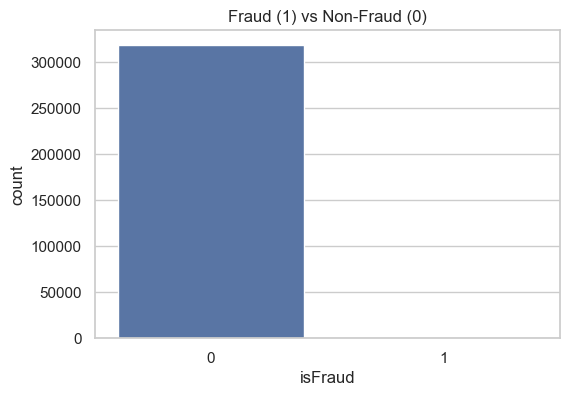

Fraud ratio (proportion of 1s): 0.000714


In [8]:
# Cell: Target distribution
if 'isFraud' not in df.columns:
    raise ValueError("Target column 'isFraud' not found. Please confirm dataset has this column.")
print(df['isFraud'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title('Fraud (1) vs Non-Fraud (0)')
plt.show()
fraud_ratio = df['isFraud'].mean()
print(f"Fraud ratio (proportion of 1s): {fraud_ratio:.6f}")


In [9]:
# Cell: Compute VIF for numeric features (safe version)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

num_df = df.select_dtypes(include=[np.number]).copy()

# Remove target column
if 'isFraud' in num_df.columns:
    num_df = num_df.drop(columns=['isFraud'])

# Drop columns with missing values
num_df = num_df.dropna(axis=1, how='any')

# Remove constant columns (zero variance)
constant_cols = [col for col in num_df.columns if num_df[col].nunique() <= 1]
if constant_cols:
    print(f"Removing constant columns: {constant_cols}")
    num_df = num_df.drop(columns=constant_cols)

print("Numeric features considered for VIF:", num_df.columns.tolist())

# Compute VIF only if column count is reasonable
if 0 < num_df.shape[1] <= 50:
    vif = pd.DataFrame()
    vif['feature'] = num_df.columns
    vif['VIF'] = [
        variance_inflation_factor(num_df.values, i) 
        for i in range(num_df.shape[1])
    ]
    vif = vif.sort_values(by='VIF', ascending=False).reset_index(drop=True)
    display(vif)
else:
    print("Skipping VIF: too many numeric columns (or none).")


Removing constant columns: ['isFlaggedFraud']
Numeric features considered for VIF: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


,feature,VIF
0,newbalanceDest,61.634383
1,oldbalanceDest,37.475544
2,amount,9.391673
3,oldbalanceOrg,1.784045
4,step,1.669302
5,newbalanceOrig,1.535147


In [10]:
# Cell: Drop ID-like columns if present
drop_candidates = ['nameOrig', 'nameDest', 'isFlaggedFraud']
for c in drop_candidates:
    if c in df.columns:
        df.drop(columns=c, inplace=True)
        print("Dropped column:", c)

# Prepare X and y
X = df.drop(columns=['isFraud'])
y = df['isFraud'].astype(int)
print("X shape:", X.shape, "y shape:", y.shape)

# Detect numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Dropped column: nameOrig
Dropped column: nameDest
Dropped column: isFlaggedFraud
X shape: (319246, 7) y shape: (319246,)
Numeric features: ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Categorical features: ['type']


In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import gc, time

# For newer scikit-learn (>=1.2)
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')

# Fit-transform to get X_prepped
t0 = time.time()
X_prep = preprocessor.fit_transform(X)
print("Preprocessing done. Prepared shape:", X_prep.shape, "Time:", time.time()-t0)
gc.collect()


Preprocessing done. Prepared shape: (319246, 11) Time: 0.4220728874206543


171

In [12]:
# Cell: Split
X_train, X_test, y_train, y_test = train_test_split(
    X_prep, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("Test class distribution:\n", pd.Series(y_test).value_counts(normalize=True))


Train shape: (255396, 11) Test shape: (63850, 11)
Train class distribution:
 isFraud
0    0.999287
1    0.000713
Name: proportion, dtype: float64
Test class distribution:
 isFraud
0    0.99928
1    0.00072
Name: proportion, dtype: float64


In [13]:
# Cell: Train models (warning-free)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

models = {}

# Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)
lr.fit(X_train, y_train)
models['LogisticRegression'] = lr
print("Done LR")

# Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
models['RandomForest'] = rf
print("Done RF")

# XGBoost
print("Training XGBoost...")
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / max(1, pos)  # to handle class imbalance

xgb = XGBClassifier(
    n_estimators=200,
    eval_metric='logloss',  # avoids use_label_encoder warning
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)
models['XGBoost'] = xgb
print("Done XGBoost")


Training Logistic Regression...
Done LR
Training Random Forest...
Done RF
Training XGBoost...
Done XGBoost


Model: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0     1.0000    0.9865    0.9932     63804
           1     0.0505    1.0000    0.0962        46

    accuracy                         0.9865     63850
   macro avg     0.5253    0.9932    0.5447     63850
weighted avg     0.9993    0.9865    0.9925     63850

Confusion matrix:
 [[62940   864]
 [    0    46]]
ROC-AUC: 0.9996 | PR-AUC (AP): 0.7048


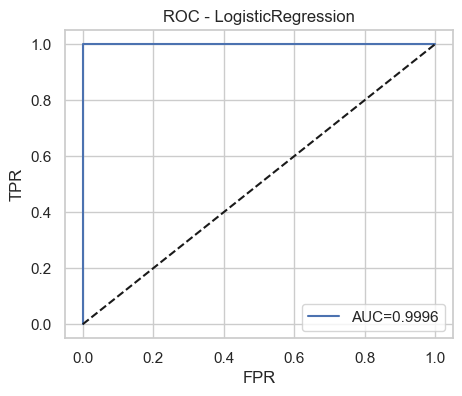

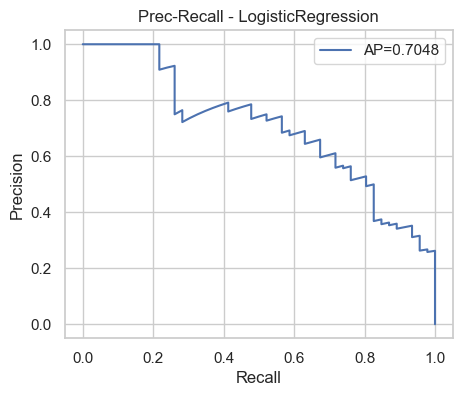

Model: RandomForest

Classification report:
               precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     63804
           1     1.0000    0.4783    0.6471        46

    accuracy                         0.9996     63850
   macro avg     0.9998    0.7391    0.8234     63850
weighted avg     0.9996    0.9996    0.9996     63850

Confusion matrix:
 [[63804     0]
 [   24    22]]
ROC-AUC: 0.9112 | PR-AUC (AP): 0.6282


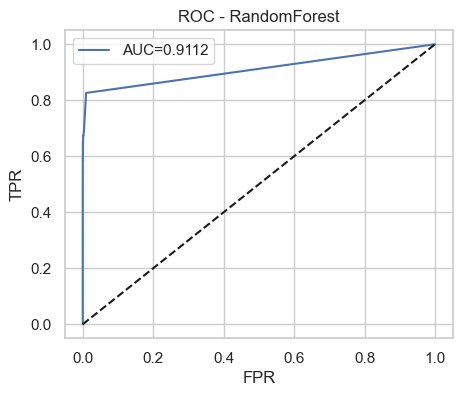

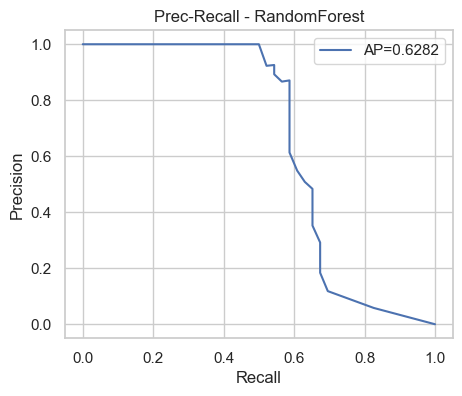

Model: XGBoost

Classification report:
               precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     63804
           1     0.6522    0.6522    0.6522        46

    accuracy                         0.9995     63850
   macro avg     0.8260    0.8260    0.8260     63850
weighted avg     0.9995    0.9995    0.9995     63850

Confusion matrix:
 [[63788    16]
 [   16    30]]
ROC-AUC: 0.9971 | PR-AUC (AP): 0.7159


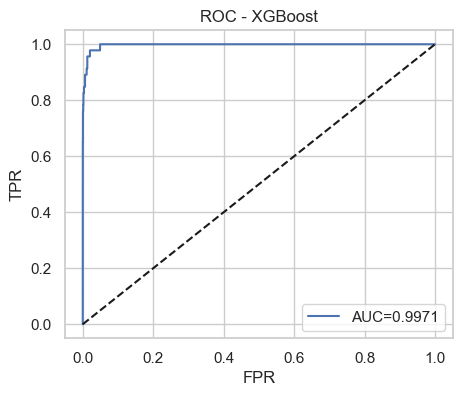

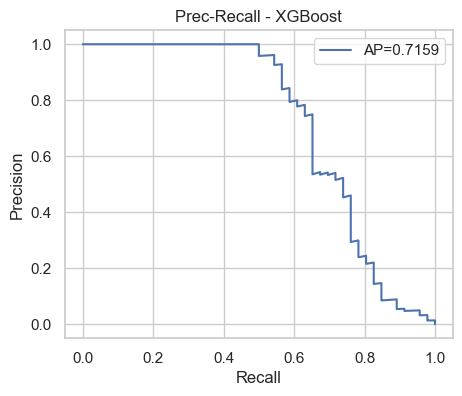

In [14]:
# Cell: Evaluation helper & run
def evaluate_model(name, model, X_test, y_test):
    print("="*40)
    print("Model:", name)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        # fallback for models without predict_proba
        y_score = model.decision_function(X_test)
        y_prob = (y_score - y_score.min())/(y_score.max()-y_score.min())
    print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob)
    print(f"ROC-AUC: {roc:.4f} | PR-AUC (AP): {pr:.4f}")

    # ROC plot
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc:.4f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC - {name}")
    plt.legend(); plt.show()

    # PR plot
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(recall, precision, label=f"AP={pr:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Prec-Recall - {name}")
    plt.legend(); plt.show()
    return roc, pr

results = {}
for name, model in models.items():
    results[name] = evaluate_model(name, model, X_test, y_test)


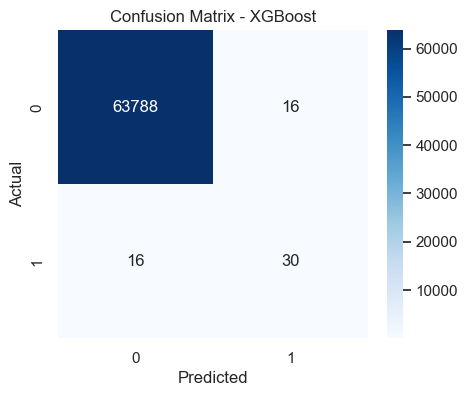

In [15]:
# Cell: Confusion matrix heatmap for XGBoost
best_name = 'XGBoost'
best_model = models[best_name]
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'Confusion Matrix - {best_name}')
plt.show()


Number of features after preprocessing: 11
Top RandomForest features:


,feature,importance
2,oldbalanceOrg,0.305816
9,type_PAYMENT,0.163053
1,amount,0.132456
10,type_TRANSFER,0.113801
5,newbalanceDest,0.104662
0,step,0.056958
3,newbalanceOrig,0.047762
4,oldbalanceDest,0.044754
7,type_CASH_OUT,0.028900
6,type_CASH_IN,0.001347


Top XGBoost features:


,feature,importance
9,type_PAYMENT,0.840171
3,newbalanceOrig,0.062469
2,oldbalanceOrg,0.033258
1,amount,0.017530
5,newbalanceDest,0.014061
7,type_CASH_OUT,0.011304
8,type_DEBIT,0.009056
10,type_TRANSFER,0.008949
4,oldbalanceDest,0.001995
0,step,0.001207


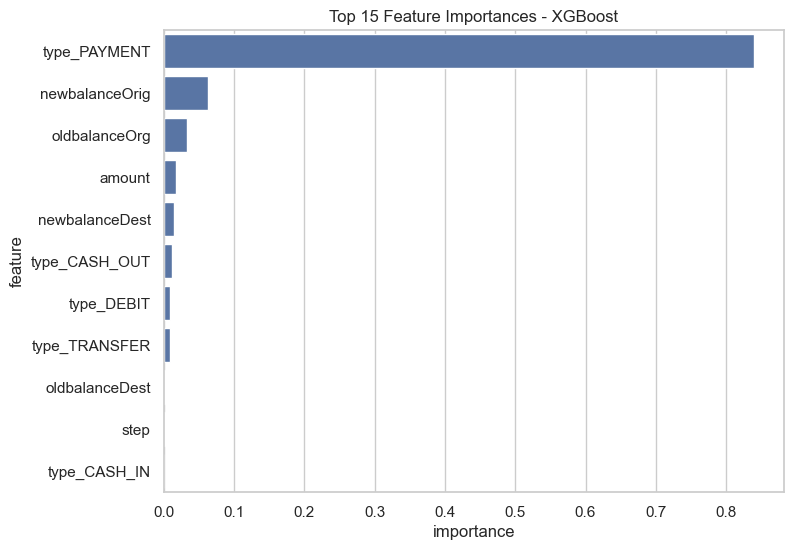

In [16]:
# Cell: Extract feature names after preprocessing
def get_feature_names(preprocessor):
    names = []
    if hasattr(preprocessor, 'transformers_'):
        for name, trans, cols in preprocessor.transformers_:
            if name == 'num':
                names.extend(cols)
            elif name == 'cat':
                # OneHotEncoder feature names
                ohe = trans.named_steps['ohe']
                cats = ohe.get_feature_names_out(cols)
                names.extend(cats.tolist())
    return names

feature_names = get_feature_names(preprocessor)
print("Number of features after preprocessing:", len(feature_names))

# RandomForest importances
rf_imp = models['RandomForest'].feature_importances_
imp_df_rf = pd.DataFrame({'feature': feature_names, 'importance': rf_imp}).sort_values('importance', ascending=False)
print("Top RandomForest features:")
display(imp_df_rf.head(15))

# XGBoost importances
xgb_imp = models['XGBoost'].feature_importances_
imp_df_xgb = pd.DataFrame({'feature': feature_names, 'importance': xgb_imp}).sort_values('importance', ascending=False)
print("Top XGBoost features:")
display(imp_df_xgb.head(15))

# Plot XGBoost top 15
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=imp_df_xgb.head(15))
plt.title('Top 15 Feature Importances - XGBoost')
plt.show()


In [17]:
# Cell: Tune threshold on XGBoost to maximize F1 on test set
y_prob = models['XGBoost'].predict_proba(X_test)[:,1]
thresholds = np.linspace(0.01, 0.99, 99)
best_t = 0.5
best_f1 = 0
for t in thresholds:
    preds = (y_prob >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"Best threshold by F1: {best_t:.3f} with F1={best_f1:.4f}")
preds_best = (y_prob >= best_t).astype(int)
print("Precision:", precision_score(y_test, preds_best))
print("Recall:", recall_score(y_test, preds_best))
print("F1:", f1_score(y_test, preds_best))


Best threshold by F1: 0.990 with F1=0.7027
Precision: 0.9285714285714286
Recall: 0.5652173913043478
F1: 0.7027027027027027


In [18]:
# Cell: Save model and preprocessor
os.makedirs('models', exist_ok=True)
joblib.dump(models['XGBoost'], 'models/xgb_model.pkl')
joblib.dump(preprocessor, 'models/preprocessor.pkl')
print("Saved XGBoost model to models/xgb_model.pkl and preprocessor to models/preprocessor.pkl")


Saved XGBoost model to models/xgb_model.pkl and preprocessor to models/preprocessor.pkl
